In [1]:
# Reading Data
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Data Preprocessing 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Building CNN Model & Pretraining Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dropout
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

# Downlaod Model
import pickle

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

Import data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/basup/OneDrive/Desktop/data/Potato",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7611 files belonging to 8 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___bacterial_wilt',
 'Potato___early_blight',
 'Potato___healthy',
 'Potato___late_blight',
 'Potato___nematode',
 'Potato___pests',
 'Potato___phytophthora',
 'Potato___virus']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 4 1 6 3 2 2 1 5 3 1 2 1 5 1 1 3 3 2 2 3 1 1 0 2 3 3 3 2 2 1 3]


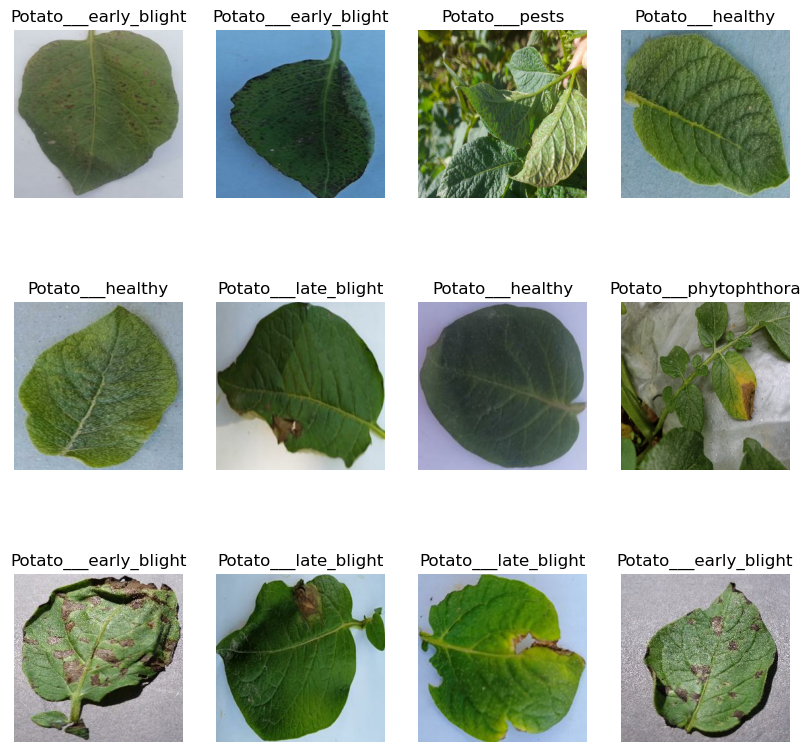

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training

Validation: Dataset to be tested against while training

Test: Dataset to be tested against after we trained a model

In [7]:
len(dataset)

238

In [8]:
train_size = 0.8
len(dataset)*train_size

190.4

In [9]:
train_ds = dataset.take(190)
len(train_ds)

190

In [10]:
test_ds = dataset.skip(190)
len(test_ds)

48

In [11]:
val_size=0.1
len(dataset)*val_size

23.8

In [12]:
val_ds = test_ds.take(23)
len(val_ds)

23

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

42

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

190

In [17]:
len(val_ds)

23

In [18]:
len(test_ds)

25

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the Model

Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.


You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.


We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. 

In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [34]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
190/190 [==============================] - 401s 2s/step - loss: 1.4180 - accuracy: 0.4212 - val_loss: 1.2096 - val_accuracy: 0.4946
Epoch 2/50
190/190 [==============================] - 396s 2s/step - loss: 1.1579 - accuracy: 0.5166 - val_loss: 1.0049 - val_accuracy: 0.6005
Epoch 3/50
190/190 [==============================] - 359s 2s/step - loss: 0.9984 - accuracy: 0.6003 - val_loss: 0.8018 - val_accuracy: 0.7011
Epoch 4/50
190/190 [==============================] - 358s 2s/step - loss: 0.8329 - accuracy: 0.6808 - val_loss: 0.7907 - val_accuracy: 0.7147
Epoch 5/50
190/190 [==============================] - 353s 2s/step - loss: 0.7233 - accuracy: 0.7202 - val_loss: 0.6414 - val_accuracy: 0.7609
Epoch 6/50
190/190 [==============================] - 353s 2s/step - loss: 0.6468 - accuracy: 0.7558 - val_loss: 1.0003 - val_accuracy: 0.6712
Epoch 7/50
190/190 [==============================] - 356s 2s/step - loss: 0.6041 - accuracy: 0.7771 - val_loss: 0.5964 - val_accuracy: 0.7704

In [36]:
scores = model.evaluate(test_ds)

25/25 [==============================] - 41s 393ms/step - loss: 0.4166 - accuracy: 0.8775


In [37]:
scores

[0.41659727692604065, 0.8774999976158142]

In [38]:
history

In [39]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 190}

In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [42]:
type(history.history['loss'])

list

In [43]:
len(history.history['loss'])

50

In [44]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.4179866313934326,
 1.1578648090362549,
 0.9984422326087952,
 0.8329384922981262,
 0.7233035564422607]

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

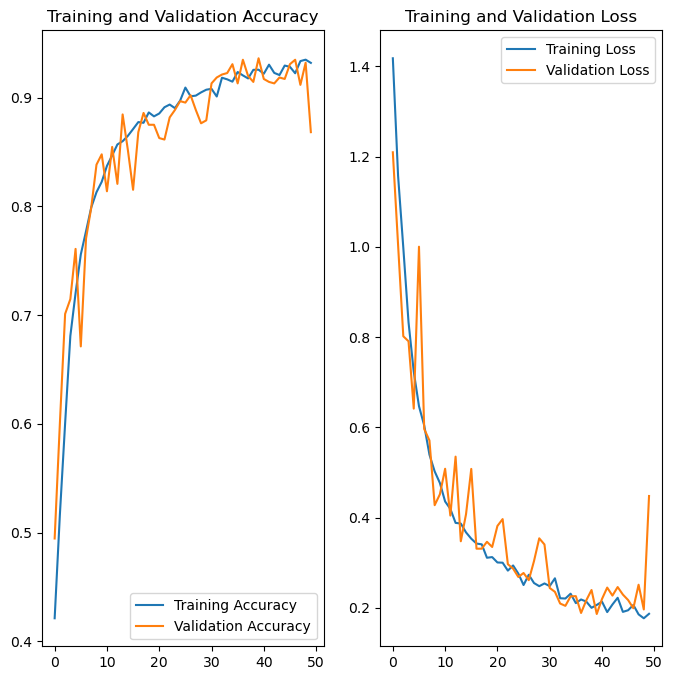

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run prediction on a sample image

first image to predict
actual label: Potato___early_blight
1/1 [==============================] - 0s 265ms/step
predicted label: Potato___early_blight


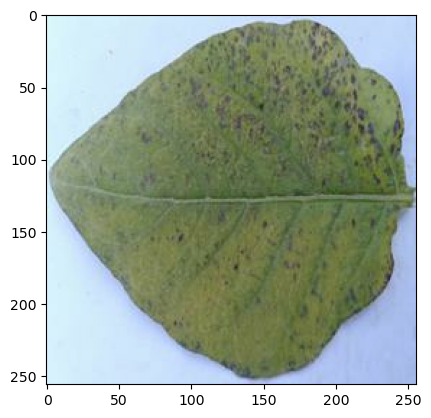

In [49]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [50]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 37ms/step


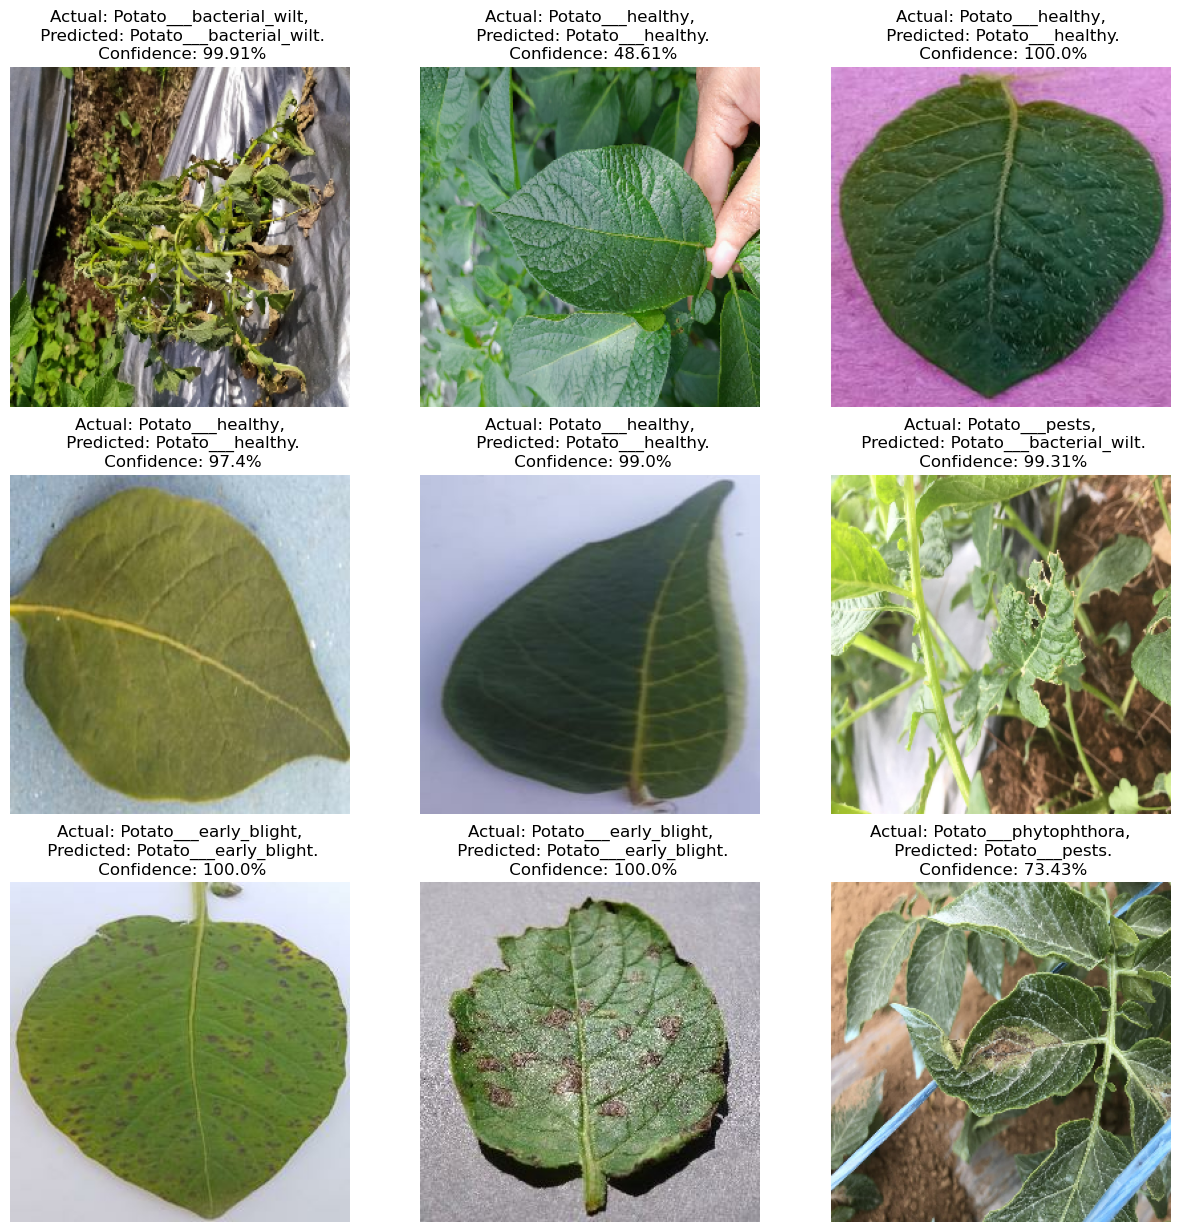

In [51]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [59]:
import os
model_version=max([int(i) for i in os.listdir("C:/Users/basup/OneDrive/Desktop/AGRIAI-IMPROVED/Back_end/MLmodels/Potato_Model") + [0]])+1
model.save(f"C:/Users/basup/OneDrive/Desktop/AGRIAI-IMPROVED/Back_end/MLmodels/{model_version}")

ValueError: invalid literal for int() with base 10: 'assets'

In [58]:
model.save("C:/Users/basup/OneDrive/Desktop/AGRIAI-IMPROVED/Back_end/MLmodels/Potato_Model")

INFO:tensorflow:Assets written to: C:/Users/basup/OneDrive/Desktop/AGRIAI-IMPROVED/Back_end/MLmodels/Potato_Model\assets


INFO:tensorflow:Assets written to: C:/Users/basup/OneDrive/Desktop/AGRIAI-IMPROVED/Back_end/MLmodels/Potato_Model\assets
